In [1]:
import transformers
from transformers import (
    pipeline,
    logging,
)
from typing import List
import torch
from torch import cuda, bfloat16
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
from pylab import rcParams
import os

In [2]:
model_id = 'hyonbokan/BGPStream13-10k-cutoff-1024-max-2048'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_8bit=True,
# )

# Need auth token for these
hf_auth = os.environ.get('hf_token')

model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    # quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=hf_auth
)


model.eval()
print(f"Model loaded on {device}")

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded on cuda:0


In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

tokenizer.pad_token = tokenizer.eos_token
# tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

# Model: BGPStream13-10k-cutoff-1024-max-2048

## Reports

### Task 1: Analysis of BGP Table Statistics
1. Use PyBGPStream (project=ris-live, exclude from_time and until_time), to preform real-time analysis of the BGP table statistics for AS131072, focusing on the characteristics of advertisements. Print the metrics evaluating the degree of similarity of the AS paths of these specific advertisements to their encompassing aggregate.

2. Write a Python script using PyBGPStream to analyze BGP advertisements for AS34549 during a specific time period from 13:00 to 14:00 on 2024-01-01. The script needs to focus on dissecting the characteristics of BGP advertisements for AS34549, especially examining the AS paths. The script is expected to calculate and present metrics assessing how similar the AS paths of individual advertisements are to those of their encompassing aggregate routes. The goal is to detect, analyze, and report any noticeable patterns in AS path similarities, indicating potential routing strategies or policy implementations by AS34549 during the indicated period. This directive aims to guide the script in analyzing a precise segment of historical BGP data, concentrating on advertisements linked to AS34549, to reveal insights into routing patterns or policy applications based on AS path analysis. Do not use filter parameter.

3. best
Develop a Python script utilizing PyBGPStream to scrutinize BGP advertisements from AS34549 within the timeframe of 13:00 to 14:00 on January 1, 2024 from collectors rrc00. The script's core objective is to compute and elucidate metrics that illustrate the degree of similarity or divergence among the AS paths of these advertisements, in comparison to a broader, aggregate perspective of AS34549's routing behavior. Through this analytical lens, the script should unveil any discernible trends or anomalies in AS path configurations, thereby shedding light on the underlying routing strategies or policy adaptations employed by AS34549. This detailed examination is intended to provide a nuanced understanding of AS34549's network routing dynamics and policy nuances during the specified window, offering a focused exploration of historical BGP advertisement data without applying the PyBGPStream 'filter' parameter.

4. 
Develop a Python script utilizing PyBGPStream to scrutinize BGP advertisements from AS34549 within the timeframe of 13:00 to 14:00 on January 1, 2024 from collectors rrc00. The script's core objective is to compute metrics that illustrate the degree of similarity or divergence among the AS paths of these advertisements, in comparison to a broader, aggregate perspective of AS34549's routing behavior. The script should unveil any discernible trends or anomalies in AS path configurations, thereby showing the underlying routing strategies or policy adaptations employed by AS34549. Do not use PyBGPStream 'filter' parameter.


In [22]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Develop a Python script utilizing PyBGPStream to scrutinize BGP advertisements from AS34549 within the timeframe of 13:00 to 14:00 on January 1, 2024 from collectors rrc00. The script's core objective is to compute and elucidate metrics that illustrate the degree of similarity or divergence among the AS paths of these advertisements, in comparison to a broader, aggregate perspective of AS34549's routing behavior. Through this analytical lens, the script should unveil any discernible trends or anomalies in AS path configurations, thereby shedding light on the underlying routing strategies or policy adaptations employed by AS34549. This detailed examination is intended to provide a nuanced understanding of AS34549's network routing dynamics and policy nuances during the specified window, offering a focused exploration of historical BGP advertisement data without applying the PyBGPStream 'filter' parameter."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1024)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Develop a Python script utilizing PyBGPStream to scrutinize BGP advertisements from AS34549 within the timeframe of 13:00 to 14:00 on January 1, 2024 from collectors rrc00. The script's core objective is to compute and elucidate metrics that illustrate the degree of similarity or divergence among the AS paths of these advertisements, in comparison to a broader, aggregate perspective of AS34549's routing behavior. Through this analytical lens, the script should unveil any discernible trends or anomalies in AS path configurations, thereby shedding light on the underlying routing strategies or policy adaptations employed by AS34549. This detailed examination is intended to provide a nuanced understanding of AS34549's network routing dynamics and policy nuances during the specified window, offering a focused exploration of historical BGP advertisement data without applying the PyBGPStream 'filter' parameter. [/INST]  Here is a Python script that utilizes PyBGPStream to scrutinize

In [ ]:
import pybgpstream

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-01-01 13:00:00", until_time="2024-01-01 14:00:00",
    collectors=["rrc00"],
    record_type="updates"
)

# Initialize a dictionary to store the AS paths
as_paths = {}

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":  # Check for BGP announcements
            as_path = elem.fields["as-path"].split()
            prefix = elem.fields["prefix"]
            as_paths[prefix] = as_path

# Compute metrics to illustrate the degree of similarity or divergence among the AS paths
for prefix, as_path in as_paths.items():
    # Compute the number of ASes in the AS path
    num_ases = len(as_path)

    # Compute the number of unique ASes in the AS path
    num_unique_ases = len(set(as_path))

    # Compute the percentage of unique ASes in the AS path
    unique_ases_percentage = (num_unique_ases / num_ases) * 100

    # Print the metrics
    print(f"Prefix: {prefix}, AS Path: {as_path}, Number of ASes: {num_ases}, Number of Unique ASes: {num_unique_ases}, Unique ASes Percentage: {unique_ases_percentage:.2f}%")

### Task 2: BGP Path Update Analysis/Report
Use PyBGPStream to collect BGP path updates for AS14061 and summarize: origin paths, next-hop paths, transit paths, first-hop changes, and prepend actions.

In [ ]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Use PyBGPStream to generate code that will collect BGP path updates for AS14061 and summarize: origin paths, next-hop paths, transit paths, first-hop changes, and prepend actions."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=718)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
import pybgpstream

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-01-01 13:00:00", until_time="2024-01-01 15:00:00",
    collectors=["rrc00"],
    record_type="updates",
    filter="peer 34549"
)

# Initialize variables
origin_paths = []
next_hop_paths = []
transit_paths = []
first_hop_changes = []
prepend_actions = []

# Loop through the stream records
for rec in stream.records():
    for elem in rec:
        # print(elem)
        if elem.type == "A":
            # Origin Paths
            if elem.fields["as-path"].startswith("34549"):
                origin_paths.append(elem.fields["as-path"])
            # Next-Hop Paths
            if elem.fields["next-hop"] == "34549":
                next_hop_paths.append(elem.fields["as-path"])
            # Transit Paths
            if elem.fields["as-path"].startswith("34549"):
                transit_paths.append(elem.fields["as-path"])
            # First-Hop Changes
            if elem.fields["as-path"].startswith("34549") and elem.fields["as-path"].split()[-1]!= elem.fields["next-hop"]:
                first_hop_changes.append(elem.fields["as-path"])
            # Prepend Actions
            if elem.fields["as-path"].startswith("34549") and elem.fields["as-path"].split()[-1] == elem.fields["next-hop"]:
                prepend_actions.append(elem.fields["as-path"])

# Print the results
print("Origin Paths:")
for path in origin_paths:
    print(path)

print("Next-Hop Paths:")
for path in next_hop_paths:
    print(path)

print("Transit Paths:")
for path in transit_paths:
    print(path)

print("First-Hop Changes:")
for path in first_hop_changes:
    print(path)

print("Prepend Actions:")
for path in prepend_actions:
    print(path)

### Task 3: BGP Path Changes
Use PyBGPStream to access live data stream (project='ris-live') and review a series of BGP update messages that show alterations in the AS_PATH attribute for key routes managed by AS14061 on the prefix 198.205.102.0/24. For each identified AS_PATH alteration, the script should detail the change, including the previous and updated AS_PATH, the affected prefix, and the timestamp of the update. Do not use 'filter' parameter.


Use PyBGPStream to access live data stream (project='ris-live') to monitor BGP update messages, specifically targeting routes managed by AS14061 with the prefix 198.205.102.0/24. The script should not use the 'filter' parameter. Instead, it should manually inspect each BGP update for the specified prefix and AS number. For every update that shows an alteration in the AS_PATH attribute for this prefix, record and output the details of the change. This includes the previous and updated AS_PATH, the affected prefix, and the timestamp of the update. Implement a way to track the last seen AS_PATH for the specified prefix so you can detect and detail any alterations in subsequent updates.

* The code has a minor erro in as-path access: as-path or origin as???
* Addition of the second message improved the quality
* 

In [27]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Use PyBGPStream to access live data stream (project='ris-live') to monitor BGP update messages, specifically targeting routes managed by AS14061 with the prefix 198.205.102.0/24. The script should not use the 'filter' parameter. Instead, it should manually inspect each BGP update for the specified prefix and AS number. For every update that shows an alteration in the AS_PATH attribute for this prefix, record and output the details of the change. This includes the previous and updated AS_PATH, the affected prefix, and the timestamp of the update. Implement a way to track the last seen AS_PATH for the specified prefix so you can detect and detail any alterations in subsequent updates."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=718)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Use PyBGPStream to access live data stream (project='ris-live') to monitor BGP update messages, specifically targeting routes managed by AS14061 with the prefix 198.205.102.0/24. The script should not use the 'filter' parameter. Instead, it should manually inspect each BGP update for the specified prefix and AS number. For every update that shows an alteration in the AS_PATH attribute for this prefix, record and output the details of the change. This includes the previous and updated AS_PATH, the affected prefix, and the timestamp of the update. Implement a way to track the last seen AS_PATH for the specified prefix so you can detect and detail any alterations in subsequent updates. [/INST]  Sure! Here's the script that uses PyBGPStream to monitor BGP update messages for the specified prefix and AS number:
```
import pybgpstream

# Initialize the BGPStream
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize the last seen AS_PATH


In [ ]:
import pybgpstream

# Initialize the BGPStream
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize the last seen AS_PATH
last_seen_as_path = None

# Loop through the stream records
for rec in stream.records():
    for elem in rec:
        as_path = elem.fields.get('as-path', '').split()
        prefix = elem.fields['prefix']
        # print(elem)
        if prefix == '67.211.53.0/24' and as_path == '6233':
            print(elem)
            # Check if the AS_PATH has changed
            if last_seen_as_path and elem.fields['as-path']!= last_seen_as_path:
                # Output the details of the change
                print(f"AS_PATH change detected for prefix 67.211.53.0/24:")
                print(f"  Previous AS_PATH: {last_seen_as_path}")
                print(f"  New AS_PATH: {elem.fields['as-path']}")
                print(f"  Timestamp: {elem.time}")
                # Update the last seen AS_PATH
                last_seen_as_path = elem.fields['as-path']

# If no changes were detected, print a message
if not last_seen_as_path:
    print("No changes detected for prefix 67.211.53.0/24.")

### Tast 3.2: Path Updates - Breakdown by Update Type
Design a script that utilizes PyBGPStream to examine BGP path updates for AS44103 from 'rrc00' collector over the period 03-02-2024 13:00 to 14:59:59, categorizing the updates by type of change in the AS Path: changes in the origin AS, changes in the origin's next-hop AS, changes in the transit AS path, changes in the first-hop AS, and changes due to AS prepending. Do not include 'fileter in the parameter.

Avoid using pronouns! - categorizing the updates, not them

In [5]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Design a script that utilizes PyBGPStream to examine BGP path updates for AS44103 from 'rrc00' collector over the period 03-02-2024 13:00 to 14:59:59, categorizing the updates by type of change in the AS Path: changes in the origin AS, changes in the origin's next-hop AS, changes in the transit AS path, changes in the first-hop AS, and changes due to AS prepending. Do not include 'fileter in the parameter."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1024)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Design a script that utilizes PyBGPStream to examine BGP path updates for AS44103 from 'rrc00' collector over the period 03-02-2024 13:00 to 14:59:59, categorizing the updates by type of change in the AS Path: changes in the origin AS, changes in the origin's next-hop AS, changes in the transit AS path, changes in the first-hop AS, and changes due to AS prepending. Do not include 'fileter in the parameter. [/INST]  Sure! Here's the script:

import pybgpstream

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-02-03 13:00:00", until_time="2024-02-03 14:59:59",
    collectors=["rrc00"],
    record_type="updates"
)

# Counter for each type of change
origin_as_changes = 0
origin_next_hop_changes = 0
transit_as_path_changes = 0
first_hop_changes = 0
as_prepending_changes = 0

# Loop through the stream records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            # Check if the update is for AS44103
            if elem.f

In [6]:
import pybgpstream

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-02-03 13:00:00", until_time="2024-02-03 14:59:59",
    collectors=["rrc00"],
    record_type="updates"
)

# Counter for each type of change
origin_as_changes = 0
origin_next_hop_changes = 0
transit_as_path_changes = 0
first_hop_changes = 0
as_prepending_changes = 0

# Loop through the stream records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            # Check if the update is for AS44103
            if elem.fields["as-path"].split()[-1] == "44103":
                # Check the type of change
                if elem.fields["as-path"].split()[0]!= elem.fields["as-path"].split()[-1]:
                    origin_as_changes += 1
                elif elem.fields["as-path"].split()[-1]!= elem.fields["as-path"].split()[-2]:
                    origin_next_hop_changes += 1
                elif elem.fields["as-path"].split()[-1]!= elem.fields["as-path"].split()[-2] and elem.fields["as-path"].split()[-1]!= elem.fields["as-path"].split()[-3]:
                    transit_as_path_changes += 1
                elif elem.fields["as-path"].split()[-1] == elem.fields["as-path"].split()[-2] and elem.fields["as-path"].split()[-1]!= elem.fields["as-path"].split()[-3]:
                    first_hop_changes += 1
                elif elem.fields["as-path"].split()[-1] == elem.fields["as-path"].split()[-2] and elem.fields["as-path"].split()[-1] == elem.fields["as-path"].split()[-3]:
                    as_prepending_changes += 1

# Print the results
print(f"Number of changes in the origin AS: {origin_as_changes}")
print(f"Number of changes in the origin's next-hop AS: {origin_next_hop_changes}")
print(f"Number of changes in the transit AS path: {transit_as_path_changes}")
print(f"Number of changes in the first-hop AS: {first_hop_changes}")
print(f"Number of changes due to AS prepending: {as_prepending_changes}")

# If there are no changes, print a message
if origin_as_changes == 0 and origin_next_hop_changes == 0 and transit_as_path_changes == 0 and first_hop_changes == 0 and as_prepending_changes == 0:
    print("No changes found.")

Number of changes in the origin AS: 288
Number of changes in the origin's next-hop AS: 0
Number of changes in the transit AS path: 0
Number of changes in the first-hop AS: 0
Number of changes due to AS prepending: 0


### Task 4: AS Announcement Trend Reporting

Create a PyBGPStream script that generates reports on the time trend of the total span of address space advertised by AS7296. The script should collect data from BGP announcements from 'rrc00', calculate the span of address space from 02-03-2024 13:00 to 14:59:59, and aggregate this data into a time-series report. Do not add ASN to 'filter' parameter.

In [ ]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Create a PyBGPStream script that generates reports on the time trend of the total span of address space advertised by AS7296. The script should collect data from BGP announcements from 'rrc00', calculate the span of address space from 02-03-2024 13:00 to 14:59:59, and aggregate this data into a time-series report. Do not add ASN in 'filter' parameter."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=718)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] script should collect data from BGP announcements from 'rrc00', calculate the span of address space from 02-03-2024 13:00 to 14:59:59, and aggregate this data into a time-series report. Do not add ASN in 'filter' parameter. [/INST]  Sure! Here's the script that collects BGP announcements from 'rrc00' and calculates the span of address space from 02-03-2024 13:00 to 14:59:59:
```
import pybgpstream

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-03-02 13:00:00",
    until_time="2024-03-02 14:59:59",
    collectors=["rrc00"],
    record_type="updates"
)

# Dictionary to store the time-series data
time_series_data = {}

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":  # Check for BGP announcements
            prefix = elem.fields["prefix"]
            as_path = elem.fields["as-path"].split()
            origin_as = as_path[-1]
            time = rec.time

            # Check if the prefix is already

In [9]:
import pybgpstream

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-02-02 13:00:00", until_time="2024-02-02 13:59:59",
    collectors=["rrc00"],
    record_type="updates",
)

# Initialize a dictionary to store the time-series data
time_series_data = {}

# Loop through the stream records
for rec in stream.records():
    for elem in rec:
        # print(elem)
        if elem.type == "A":
            prefix = elem.fields["prefix"]
            as_path = elem.fields["as-path"].split()
            origin_as = as_path[-1]
            if origin_as == "7296":
                if prefix not in time_series_data:
                    time_series_data[prefix] = 0
                time_series_data[prefix] += 1

# Generate the time-series report
for prefix, count in time_series_data.items():
    print(f"Prefix: {prefix}, Count: {count}")

Prefix: 2606:6e00:8000::/35, Count: 9132
Prefix: 2606:6e00:4000::/35, Count: 8468
Prefix: 2606:6e00::/32, Count: 9784
Prefix: 2606:6e00:c000::/35, Count: 3466
Prefix: 23.26.72.0/24, Count: 1
Prefix: 66.171.240.0/24, Count: 1
Prefix: 66.171.241.0/24, Count: 1
Prefix: 66.171.242.0/24, Count: 1
Prefix: 66.171.243.0/24, Count: 1
Prefix: 66.171.244.0/24, Count: 1
Prefix: 66.171.245.0/24, Count: 1
Prefix: 66.171.246.0/24, Count: 1
Prefix: 66.171.247.0/24, Count: 1
Prefix: 66.171.248.0/24, Count: 1
Prefix: 66.171.249.0/24, Count: 1
Prefix: 66.171.250.0/24, Count: 1
Prefix: 66.171.251.0/24, Count: 1
Prefix: 66.171.252.0/24, Count: 1
Prefix: 66.171.253.0/24, Count: 1
Prefix: 66.171.254.0/24, Count: 1
Prefix: 66.171.255.0/24, Count: 1
Prefix: 66.186.0.0/24, Count: 1
Prefix: 66.186.1.0/24, Count: 1
Prefix: 66.186.2.0/24, Count: 1
Prefix: 66.186.3.0/24, Count: 1
Prefix: 66.186.4.0/24, Count: 1
Prefix: 66.186.5.0/24, Count: 1
Prefix: 66.186.6.0/24, Count: 1
Prefix: 66.186.7.0/24, Count: 1
Prefix: 6

### Task 5: BGP Update Reports 
Write a PyBGPStream script that analyzes BGP updates for AS59919 during the period from 03-02-2024 13:00 to 13:59:59, focusing specifically on IPv4 updates from collectors 'rrc00' and 'rrc01'. The script needs to report the total number of changes in the Forwarding Information Base (FIB). Break down the changes into three main categories: announcements, withdrawals, and path changes as well as classifying them by their IPv4 prefix lengths.

In [12]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Write a PyBGPStream script that analyzes BGP updates for AS59919 during the period from 03-02-2024 13:00 to 13:59:59, focusing specifically on IPv4 updates from collectors 'rrc00' and 'rrc01'. The script needs to report the total number of changes in the Forwarding Information Base (FIB). Break down the changes into three main categories: announcements, withdrawals, and path changes as well as classifying them by their IPv4 prefix lengths."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1024)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Write a PyBGPStream script that analyzes BGP updates for AS59919 during the period from 03-02-2024 13:00 to 13:59:59, focusing specifically on IPv4 updates from collectors 'rrc00' and 'rrc01'. The script needs to report the total number of changes in the Forwarding Information Base (FIB). Break down the changes into three main categories: announcements, withdrawals, and path changes as well as classifying them by their IPv4 prefix lengths. [/INST]  Sure! Here's the PyBGPStream script that analyzes BGP updates for AS59919 during the specified period:
```
import pybgpstream

# Initialize the BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-02-03 13:00:00",
    until_time="2024-02-03 13:59:59",
    collectors=["rrc00", "rrc01"],
    record_type="updates"
)

# Initialize a dictionary to store the results
results = {}

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":  # BGP announcements
            prefix = elem.fie

In [13]:
import pybgpstream

# Initialize the BGPStream
stream = pybgpstream.BGPStream(
    from_time="2024-02-03 13:00:00",
    until_time="2024-02-03 13:59:59",
    collectors=["rrc00", "rrc01"],
    record_type="updates"
)

# Initialize a dictionary to store the results
results = {}

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":  # BGP announcements
            prefix = elem.fields["prefix"]
            as_path = elem.fields["as-path"].split()
            origin_as = as_path[-1]
            if origin_as == "59919":
                if prefix in results:
                    results[prefix]["announcements"] += 1
                else:
                    results[prefix] = {
                        "announcements": 1,
                        "withdrawals": 0,
                        "path_changes": 0
                    }
        elif elem.type == "W":  # BGP withdrawals
            prefix = elem.fields["prefix"]
            if prefix in results:
                results[prefix]["withdrawals"] += 1
        elif elem.type == "R":  # BGP path changes
            prefix = elem.fields["prefix"]
            if prefix in results:
                results[prefix]["path_changes"] += 1

# Analyze the results
for prefix, data in results.items():
    print(f"Prefix: {prefix}")
    print(f"  Announcements: {data['announcements']}")
    print(f"  Withdrawals: {data['withdrawals']}")
    print(f"  Path Changes: {data['path_changes']}")
    print()

# Summarize the results
total_changes = 0
for prefix, data in results.items():
    total_changes += data["announcements"] + data["withdrawals"] + data["path_changes"]

print(f"Total number of changes in the Forwarding Information Base (FIB): {total_changes}")

# Break down the changes into three main categories
announcements = 0
withdrawals = 0
path_changes = 0
for prefix, data in results.items():
    announcements += data["announcements"]
    withdrawals += data["withdrawals"]
    path_changes += data["path_changes"]

print(f"Announcements: {announcements}")
print(f"Withdrawals: {withdrawals}")
print(f"Path Changes: {path_changes}")

# Classify the changes by their IPv4 prefix lengths
for prefix, data in results.items():
    if len(prefix.split("/")) == 1:
        print(f"IPv4 Prefix Length: /32")
    elif len(prefix.split("/")) == 2:
        print(f"IPv4 Prefix Length: /24")
    else:
        print(f"IPv4 Prefix Length: /16 or longer")

Prefix: 5.178.88.0/21
  Announcements: 3
  Withdrawals: 0
  Path Changes: 0

Prefix: 185.248.240.0/22
  Announcements: 4
  Withdrawals: 0
  Path Changes: 0

Prefix: 45.152.144.0/22
  Announcements: 4
  Withdrawals: 0
  Path Changes: 0

Prefix: 2a01:9ac0::/32
  Announcements: 4
  Withdrawals: 0
  Path Changes: 0

Prefix: 185.204.220.0/22
  Announcements: 2
  Withdrawals: 0
  Path Changes: 0

Prefix: 185.136.136.0/22
  Announcements: 2
  Withdrawals: 0
  Path Changes: 0

Prefix: 185.187.172.0/22
  Announcements: 2
  Withdrawals: 0
  Path Changes: 0

Prefix: 2.59.140.0/22
  Announcements: 2
  Withdrawals: 0
  Path Changes: 0

Prefix: 185.60.188.0/22
  Announcements: 2
  Withdrawals: 0
  Path Changes: 0

Total number of changes in the Forwarding Information Base (FIB): 25
Announcements: 25
Withdrawals: 0
Path Changes: 0
IPv4 Prefix Length: /24
IPv4 Prefix Length: /24
IPv4 Prefix Length: /24
IPv4 Prefix Length: /24
IPv4 Prefix Length: /24
IPv4 Prefix Length: /24
IPv4 Prefix Length: /24
IPv4

## Anomaly detection

### Task 1:
Use PyBGPStream to access ris-live and monitor BGP announcements, focusing on the five most advertised prefixes for AS7262. The script should collect data in five-minute intervals. After gathering the data, create a bar graph to visualize the frequency of announcements for each of these top prefixes. 

Write a Python script using PyBGPStream to access the 'ris-live' project and monitor BGP announcements for AS7262, specifically aiming to identify the five most advertised prefixes. The script should collect data over a specified period, tracking both announcements and withdrawals in real-time. Utilize pandas DataFrames to organize the collected data, categorizing records by time, prefix, and count. After the data collection phase - 72000 seconds, aggregate the data to highlight the most frequently announced prefixes. Finally, use matplotlib to create bar graphs visualizing the frequency of announcements and withdrawals for these top prefixes. Do not include from_time and until_time parameters.

In [ ]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Develop a Python script leveraging PyBGPStream to tap into the 'ris-live' data stream, focusing on analyzing BGP announcements for AS7262. The objective is to pinpoint the five most frequently advertised prefixes. Instead of configuring the time duration directly in PyBGPStream parameters, implement the timing mechanism within the script to manage a data collection window of 72000 seconds. Use pandas DataFrames to systematically record and categorize each BGP update by timestamp, prefix, and type (announcement or withdrawal). Post-collection, process this data to ascertain and rank the top advertised prefixes. Conclude with generating bar graphs via matplotlib, showcasing the advertisement and withdrawal frequencies of these prefixes, thus providing a visual summary of the BGP activity for AS7262 over the specified period. Do not include from_time and until_time parameters."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1024)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Develop a Python script leveraging PyBGPStream to tap into the 'ris-live' data stream, focusing on analyzing BGP announcements for AS7262. The objective is to pinpoint the five most frequently advertised prefixes. Instead of configuring the time duration directly in PyBGPStream parameters, implement the timing mechanism within the script to manage a data collection window of 72000 seconds. Use pandas DataFrames to systematically record and categorize each BGP update by timestamp, prefix, and type (announcement or withdrawal). Post-collection, process this data to ascertain and rank the top advertised prefixes. Conclude with generating bar graphs via matplotlib, showcasing the advertisement and withdrawal frequencies of these prefixes, thus providing a visual summary of the BGP activity for AS7262 over the specified period. [/INST]  Sure! Here's the Python script leveraging PyBGPStream to analyze BGP announcements for AS7262 over a 72000-second window:
```
import pybgpstream
i

In [ ]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt

# Initialize PyBGPStream
stream = pybgpstream.BGPStream(
    # from_time="2021-01-01 00:00:00", until_time="2021-01-01 00:00:72000",
    project="ris",
    collectors="rrc00",
    record_type="updates",
    filter="peer 7262"
)

# Create a DataFrame to store the BGP updates
df = pd.DataFrame(columns=['timestamp', 'prefix', 'type'])

# Loop through the stream records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            df = df.append({'timestamp': rec.time, 'prefix': elem.fields['prefix'], 'type': 'announcement'}, ignore_index=True)
        elif elem.type == "W":
            df = df.append({'timestamp': rec.time, 'prefix': elem.fields['prefix'], 'type': 'withdrawal'}, ignore_index=True)

# Group the DataFrame by prefix and type
df_grouped = df.groupby(['prefix', 'type']).size().reset_index(name='counts')

# Sort the DataFrame by counts in descending order
df_grouped.sort_values(by='counts', inplace=True, ascending=False)

# Generate bar graphs for each prefix
for prefix, type in df_grouped.groupby('prefix'):
    plt.bar(prefix, type, align='center')
    plt.xlabel(f"Prefixes Announced/Withdrawn by AS7262")
    plt.ylabel(f"Number of Updates ({type})")
    plt.title(f"Top 5 Most Frequently Advertised Prefixes for AS7262")
    plt.show()

### Task 2: Prefix announcements report 60 sec
Create a Python script using PyBGPStream and pandas to track and visualize BGP announcements for AS7262 from 'ris-live' every 60 seconds. The script should collect updates, segregate announcements and withdrawals into DataFrames, and aggregate this data to identify the top advertised prefixes. At the end of each interval, use matplotlib to generate bar graphs showing the frequency of updates per prefix. Implement threading to automate the collection and visualization process in 60-second cycles for a predetermined duration. Ensure DataFrames are cleared after each plotting to accurately reflect new data in subsequent intervals.


Construct a Python script with PyBGPStream and pandas to monitor BGP announcements for AS7262, aiming to identify the top advertised prefixes. The script should initiate a BGPStream instance focused on 'ris-live' updates. Rather than setting a static time frame within PyBGPStream's parameters, employ a dynamic approach to manage data collection over a duration, such as 72000 seconds, directly in your code logic. Accumulate update data in a pandas DataFrame, tracking each prefix occurrence. After collecting data, aggregate and sort this information to determine the most frequently announced prefixes. Utilize matplotlib to periodically generate and display bar graphs, visualizing the count of announcements per prefix. Implement threading to facilitate continuous data collection and visualization in 60-second intervals, refreshing the DataFrame after each cycle.

`With visualization`


"Write a Python script utilizing PyBGPStream and pandas to dynamically monitor and analyze BGP updates for AS7262, capturing both announcements and withdrawals. The script should operate within an infinite loop, continuously fetching data from the 'ris-live' project stream without pre-set time filters. Initialize a pandas DataFrame to log each relevant update's prefix and a count placeholder. Implement a threading mechanism to periodically collect this data in real time. Within the data collection function, filter updates by checking for AS7262 in the AS path of each update message. After collecting the data, clear the DataFrame for the next data collection cycle to avoid duplication. Additionally, set up a separate function to visualize the aggregated data using matplotlib, creating bar graphs to display the frequency of announcements for the top advertised prefixes by AS7262. This visualization should occur at regular intervals, every 60 seconds, to provide an ongoing analysis. Ensure the visualization function is called outside the data collection thread to maintain continuous monitoring and reporting. Include safety checks to terminate the script gracefully if the data collection thread stops running."

Develop a Python script leveraging PyBGPStream and pandas to monitor BGP updates from AS7262 in real time, focusing on capturing both announcements and withdrawals. Start by setting up a BGPStream instance for the 'ris-live' project, ensuring real-time updates are fetched without time constraints. Initialize two pandas DataFrames for logging prefix announcements and withdrawals, each with 'Time', 'Prefix', and 'Count' columns. Create a function to process BGP data, filtering for updates related to AS7262 by checking the AS path, and update the DataFrames accordingly. This function should collect data, then visualize the frequency of announcements and withdrawals for top prefixes, and it should reset the DataFrames after each visualization to avoid data duplication. Utilize threading to allow this function to run in a loop, ensuring continuous data monitoring and visualization every 60 seconds over a predefined total period of 180 seconds. Include necessary checks to gracefully exit if the data collection thread stops, ensuring the script maintains continuous, updated analysis of BGP activity for AS7262.


Create a Python script using PyBGPStream and pandas to dynamically monitor BGP updates from AS7262, capturing both announcements and withdrawals in real time. Begin by setting up a BGPStream instance targeting the 'ris-live' project to fetch updates continuously, without imposing time constraints. Then, initialize two pandas DataFrames named announcements and withdrawals, each with columns for 'Time', 'Prefix', and 'Count', to log the events. Write a process_bgp_data function that iterates through BGP records, filtering for AS7262 by checking the AS path in each update message. Update the respective DataFrame with each announcement or withdrawal, appending new data with the current time, prefix, and incrementing the count for occurrences. After data collection, call a visualize_data function to display the aggregated data using matplotlib bar graphs, showing the frequency of events for top prefixes. Use threading to run process_bgp_data in a continuous loop, allowing for data collection and visualization every 60 seconds over a predefined total duration of 180 seconds. Ensure the script includes checks to gracefully exit if the data collection thread stops and to reset the DataFrames after each visualization cycle to avoid data duplication, maintaining an updated analysis of BGP activity for AS7262. This structured approach ensures the script provides continuous monitoring and timely insights into BGP updates related to AS7262.



Develop a Python script that utilizes PyBGPStream and pandas to continuously monitor BGP updates for AS7262, focusing on both announcements and withdrawals. The script will set up a BGPStream instance to fetch updates from the 'ris-live' project without specifying 'from_time' and 'until_time', enabling real-time data capture. Two pandas DataFrames, announcements and withdrawals, will be initialized with columns for 'Time', 'Prefix', and 'Count' to log respective events. Create a function, process_bgp_data, to iterate over the BGP records fetched by PyBGPStream. This function should filter updates by examining the AS path within each message, checking for the presence of AS7262. For relevant updates, increment the count of occurrences in the respective DataFrame and annotate the event with the current time and involved prefix. To ensure continuous monitoring and analysis, employ threading to run process_bgp_data in an infinite loop, executing every 60 seconds. In parallel, set up a visualization function, visualize_data, which aggregates data from the DataFrames to calculate the total count of announcements and withdrawals per prefix. Use matplotlib to generate bar graphs displaying these frequencies, updating the visualization in a separate loop also running every 60 seconds. Incorporate logic to reset the DataFrames after each visualization cycle to prevent data duplication and ensure the script provides up-to-date analysis. Finally, include checks to gracefully handle the termination of the data collection thread, ensuring the script exits cleanly if data collection is interrupted or continues seamlessly otherwise.

In [ ]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Develop a Python script that utilizes PyBGPStream and pandas to continuously monitor BGP updates for AS7262, focusing on both announcements and withdrawals. The script will set up a BGPStream instance to fetch updates from the 'ris-live' project without specifying 'from_time' and 'until_time', enabling real-time data capture. Two pandas DataFrames, announcements and withdrawals, will be initialized with columns for 'Time', 'Prefix', and 'Count' to log respective events. Create a function, process_bgp_data, to iterate over the BGP records fetched by PyBGPStream. This function should filter updates by examining the AS path within each message, checking for the presence of AS7262. For relevant updates, increment the count of occurrences in the respective DataFrame and annotate the event with the current time and involved prefix. To ensure continuous monitoring and analysis, employ threading to run process_bgp_data in an infinite loop, executing every 60 seconds. In parallel, set up a visualization function, visualize_data, which aggregates data from the DataFrames to calculate the total count of announcements and withdrawals per prefix. Use matplotlib to generate bar graphs displaying these frequencies, updating the visualization in a separate loop also running every 60 seconds. Incorporate logic to reset the DataFrames after each visualization cycle to prevent data duplication and ensure the script provides up-to-date analysis. Finally, include checks to gracefully handle the termination of the data collection thread, ensuring the script exits cleanly if data collection is interrupted or continues seamlessly otherwise."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1500)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

# Initialize BGPStream instance
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize DataFrames for announcements and withdrawals
announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])

# Define function to process BGP data
def process_bgp_data():
    global announcements, withdrawals
    while True:
        # Fetch BGP records
        for rec in stream.records():
            for elem in rec: # mannually added
                # Filter records with AS7262 in the AS path
                as_path = elem.fields.get('as-path', '').split() # mannually added
                if '24482' in as_path:
                    print("\n 24482 as path found... \n")
                    # Correctly format the time string using the record's timestamp
                    time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
                    prefix = elem.fields['prefix']
                    print(f"\n 24482 prefix: {prefix}; type: {elem.type} \n")
                    # Determine the correct DataFrame based on the type of update
                    df = announcements if elem.type == 'A' else withdrawals
                    # Check if a row exists for this time and prefix
                    row_index = df[(df['Time'] == time_str) & (df['Prefix'] == prefix)].index
                    if row_index.empty:
                        df.loc[len(df)] = [time_str, prefix, 1]
                    else:
                        df.loc[row_index, 'Count'] += 1
                    print(announcements)

        # Visualize data
        visualize_data()
        # Sleep for 60 seconds
        time.sleep(60)


def visualize_data():
    # Ensure global DataFrames are accessible
    global announcements, withdrawals
    
    # Aggregate counts by prefix for announcements and withdrawals
    agg_announcements = announcements.groupby('Prefix')['Count'].sum().reset_index()
    agg_withdrawals = withdrawals.groupby('Prefix')['Count'].sum().reset_index()

    # Sort and get the top 5 prefixes for announcements and withdrawals
    top_announcements = agg_announcements.sort_values(by='Count', ascending=False).head(5)
    top_withdrawals = agg_withdrawals.sort_values(by='Count', ascending=False).head(5)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot the top 5 announcements
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.bar(top_announcements['Prefix'], top_announcements['Count'], color='blue')
    plt.title('Top 5 Announced Prefixes')
    plt.xlabel('Prefix')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    # Plot the top 5 withdrawals
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.bar(top_withdrawals['Prefix'], top_withdrawals['Count'], color='red')
    plt.title('Top 5 Withdrawn Prefixes')
    plt.xlabel('Prefix')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # Reset DataFrames for the next iteration to ensure freshness of data
    announcements = announcements.iloc[0:0]
    withdrawals = withdrawals.iloc[0:0]

# Start data collection thread
thread = threading.Thread(target=process_bgp_data)
thread.start()

while True:
    # Visualize data
    visualize_data()
    # Sleep for 60 seconds
    time.sleep(60)

# Gracefully handle termination
if thread.is_alive():
    thread.terminate()
    print("Data collection thread terminated.")
else:
    print("Data collection thread already terminated.")
    break

`no visual`

1. Best  
Create a Python script that leverages the PyBGPStream library for real-time monitoring of BGP updates, focusing specifically on the announcements and withdrawals related to a particular Autonomous System (AS), here marked as '24482'. Initialize the script by setting up a BGPStream instance configured to fetch updates from the 'ris-live' project. Prepare two pandas DataFrames, one each for tracking announcements and withdrawals, with columns for the time of the update, the prefix involved, and a count of occurrences. Design a function called process_bgp_data that operates continuously for a predetermined duration, here 180 seconds, to collect BGP updates. Within this function, filter the updates to identify those related to the AS of interest and update the respective DataFrame by either adding a new row for each unique prefix occurrence or incrementing the count for existing entries. Implement a mechanism to print out the top 5 prefixes by count from each DataFrame every 60 seconds, showcasing the most frequent announcements and withdrawals during that period before resetting the DataFrames for the next cycle of data collection. Initiate this data collection process in a separate thread to allow for concurrent execution without blocking other operations. Ensure that the entire script is designed to provide insights into the most active prefixes related to the specified AS within the live BGP feed, offering valuable information on BGP dynamics over a short, specified timeframe.

1.1 filter and get AS path method:


2. Fail. Confusing prompt for LLM.
Develop a Python script using PyBGPStream to monitor BGP updates in real time, with a focus on a specific AS '24482'. Begin by initializing a BGPStream instance to collect updates from the 'ris-live' project. Do not use from_time and until_time in PyBGPStream parameters. Set up two pandas DataFrames for recording BGP announcements and withdrawals. Each DataFrame should include columns to record the time of the update, the involved prefix, and a count of how often each prefix occurs. Create a function named process_bgp_data, designed to run for a set duration of 180 seconds by implementing a mechanism using time.time() to capture the start timestamp and gather BGP update data continuously throughout this period. In this function, use as_path = elem.fields.get('as-path', '').split() to filter updates related to the AS of interest. Instead of appending new rows to the DataFrame directly, identify existing entries by filtering on both the time and prefix. If an entry exists, increment its count; if not, use the DataFrame's .loc method to add a new row, avoiding the use of the append method. Every 60 seconds, the script should print the top 5 prefixes by count for both announcements and withdrawals. After printing, reset the DataFrames to ensure fresh data for the next collection cycle. Launch process_bgp_data function in a separate thread, enabling it to run alongside other operations without interference.



In [10]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Create a Python script that leverages the PyBGPStream library for real-time monitoring of BGP updates, focusing specifically on the announcements and withdrawals related to a particular Autonomous System (AS), here marked as '24482'. Initialize the script by setting up a BGPStream instance configured to fetch updates from the 'ris-live' project. Prepare two pandas DataFrames, one each for tracking announcements and withdrawals, with columns for the time of the update, the prefix involved, and a count of occurrences. Design a function called process_bgp_data that operates continuously for a predetermined duration, here 180 seconds, to collect BGP updates. Within this function, filter the updates to identify those related to the AS of interest and update the respective DataFrame by either adding a new row for each unique prefix occurrence or incrementing the count for existing entries. Implement a mechanism to print out the top 5 prefixes by count from each DataFrame every 60 seconds, showcasing the most frequent announcements and withdrawals during that period before resetting the DataFrames for the next cycle of data collection. Initiate this data collection process in a separate thread to allow for concurrent execution without blocking other operations. Ensure that the entire script is designed to provide insights into the most active prefixes related to the specified AS within the live BGP feed, offering valuable information on BGP dynamics over a short, specified timeframe."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1424)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Create a Python script that leverages the PyBGPStream library for real-time monitoring of BGP updates, focusing specifically on the announcements and withdrawals related to a particular Autonomous System (AS), here marked as '24482'. Initialize the script by setting up a BGPStream instance configured to fetch updates from the 'ris-live' project. Prepare two pandas DataFrames, one each for tracking announcements and withdrawals, with columns for the time of the update, the prefix involved, and a count of occurrences. Design a function called process_bgp_data that operates continuously for a predetermined duration, here 180 seconds, to collect BGP updates. Within this function, filter the updates to identify those related to the AS of interest and update the respective DataFrame by either adding a new row for each unique prefix occurrence or incrementing the count for existing entries. Implement a mechanism to print out the top 5 prefixes by count from each DataFrame every 60 s

In [12]:
import pybgpstream
import pandas as pd
import threading
import time

# Initialize BGPStream instance
stream = pybgpstream.BGPStream(
    from_time="2023-03-10 15:00:00", until_time="2023-03-10 16:00:00",
    project="ris-live",
    record_type="updates",
    # filter="type announcement and collector ris-live and prefix more 24482"
)

# Initialize DataFrames for announcements and withdrawals
announcements = pd.DataFrame(columns=['time', 'prefix', 'count'])
withdrawals = pd.DataFrame(columns=['time', 'prefix', 'count'])

# Process BGP data
def process_bgp_data():
    global announcements, withdrawals
    while True:
        # Fetch BGP updates
        for rec in stream.records():
            for elem in rec:
                if elem.type == 'A':
                    # Add new row for each unique prefix occurrence
                    if elem.fields['prefix'] not in announcements['prefix'].values:
                        announcements = announcements.append({'time': time.time(), 'prefix': elem.fields['prefix'], 'count': 1}, ignore_index=True)
                    else:
                        announcements.loc[announcements['prefix'] == elem.fields['prefix'], 'count'] += 1
                elif elem.type == 'W':
                    # Increment count for existing entries
                    withdrawals.loc[withdrawals['prefix'] == elem.fields['prefix'], 'count'] += 1

        # Print top 5 prefixes by count every 60 seconds
        print("Top 5 Announcements:")
        print(announcements.sort_values(by='count', ascending=False).head(5))
        print("Top 5 Withdrawals:")
        print(withdrawals.sort_values(by='count', ascending=False).head(5))
        # Reset DataFrames
        announcements = announcements.reset_index(drop=True)
        withdrawals = withdrawals.reset_index(drop=True)
        # Wait for 60 seconds
        time.sleep(60)

# Start thread for concurrent execution
thread = threading.Thread(target=process_bgp_data)
thread.start()

# Run for 180 seconds
total_time = 180
while time.time() < total_time:
    thread.run()
    # Wait for 60 seconds
    time.sleep(60)

# Print final results
print("Top 5 Announcements:")
print(announcements.sort_values(by='count', ascending=False).head(5))
print("Top 5 Withdrawals:")
print(withdrawals.sort_values(by='count', ascending=False).head(5))

2024-03-12 13:23:27 1000701: bgpstream_filter.c:307: ERROR: record-type filter must be one of "ribs" or "updates"


ValueError: Invalid filter string: type announcement and collector ris-live and prefix more 24482

### change prompt

"Change the AS number to 7812 and total run time to 500. Add a function that will plot the top prefix announcements and withdrawals along with print statements."

In [ ]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

# Initialize BGPStream instance
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize DataFrames for announcements and withdrawals
announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])

def process_bgp_data(stop_time):
    global announcements, withdrawals
    end_time = time.time() + stop_time  # Calculate end time based on stop_time duration
    last_print_time = time.time()

    while time.time() < end_time:
        for rec in stream.records():
            for elem in rec:
                # Filter records with AS7262 in the AS path
                as_path = elem.fields.get('as-path', '').split()
                if '24482' in as_path:
                    time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
                    prefix = elem.fields['prefix']
                    df = announcements if elem.type == 'A' else withdrawals
                    row_index = df[(df['Time'] == time_str) & (df['Prefix'] == prefix)].index
                    if row_index.empty:
                        df.loc[len(df)] = [time_str, prefix, 1]
                    else:
                        df.loc[row_index, 'Count'] += 1

            # Check if it's time to print and reset DataFrames (every 60 seconds)
            if time.time() - last_print_time >= 60:
                # Sort and get the top 5 prefixes by count for announcements
                top_announcements = announcements.sort_values(by='Count', ascending=False).head(5)
                # Sort and get the top 5 prefixes by count for withdrawals
                top_withdrawals = withdrawals.sort_values(by='Count', ascending=False).head(5)
                
                print("Top 5 Announcements:\n", top_announcements)
                print("Top 5 Withdrawals:\n", top_withdrawals)
                
                announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
                withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
                last_print_time = time.time()  # Update last_print_time

    print("Data collection finished.")

# Define the total running time (180 seconds)
total_running_time = 180

# Start data collection thread
data_collection_thread = threading.Thread(target=process_bgp_data, args=(total_running_time,))
data_collection_thread.start()

In [ ]:
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt_input = "Change the AS number to 7812 and total run time to 500. Add a function that will plot a bar graph with the top 5 prefix announcements and withdrawals along with print statements."
prompt_output = """
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

# Initialize BGPStream instance
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize DataFrames for announcements and withdrawals
announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])

def process_bgp_data(stop_time):
    global announcements, withdrawals
    end_time = time.time() + stop_time  # Calculate end time based on stop_time duration
    last_print_time = time.time()

    while time.time() < end_time:
        for rec in stream.records():
            for elem in rec:
                # Filter records with 24482 in the AS path
                as_path = elem.fields.get('as-path', '').split()
                if '24482' in as_path:
                    time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
                    prefix = elem.fields['prefix']
                    df = announcements if elem.type == 'A' else withdrawals
                    row_index = df[(df['Time'] == time_str) & (df['Prefix'] == prefix)].index
                    if row_index.empty:
                        df.loc[len(df)] = [time_str, prefix, 1]
                    else:
                        df.loc[row_index, 'Count'] += 1

            # Check if it's time to print and reset DataFrames (every 60 seconds)
            if time.time() - last_print_time >= 60:
                # Sort and get the top 5 prefixes by count for announcements
                top_announcements = announcements.sort_values(by='Count', ascending=False).head(5)
                # Sort and get the top 5 prefixes by count for withdrawals
                top_withdrawals = withdrawals.sort_values(by='Count', ascending=False).head(5)
                
                print("Top 5 Announcements:\n", top_announcements)
                print("Top 5 Withdrawals:\n", top_withdrawals)
                
                announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
                withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
                last_print_time = time.time()  # Update last_print_time

    print("Data collection finished.")

# Define the total running time (180 seconds)
total_running_time = 180

# Start data collection thread
data_collection_thread = threading.Thread(target=, args=(total_running_time,))
data_collection_thread.start()
"""
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=2056)
result = pipe(f"<s>[INST] {prompt_input} {prompt_output} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Change the AS number to 7812 and total run time to 500. Add a function that will plot the top prefix announcements and withdrawals along with print statements. 
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

# Initialize BGPStream instance
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize DataFrames for announcements and withdrawals
announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])

def process_bgp_data(stop_time):
    global announcements, withdrawals
    end_time = time.time() + stop_time  # Calculate end time based on stop_time duration
    last_print_time = time.time()

    while time.time() < end_time:
        for rec in stream.records():
            for elem in rec:
                # Filter records with 24482 in the AS path
                as_path = elem.fields.get('as-path', '').split()
  

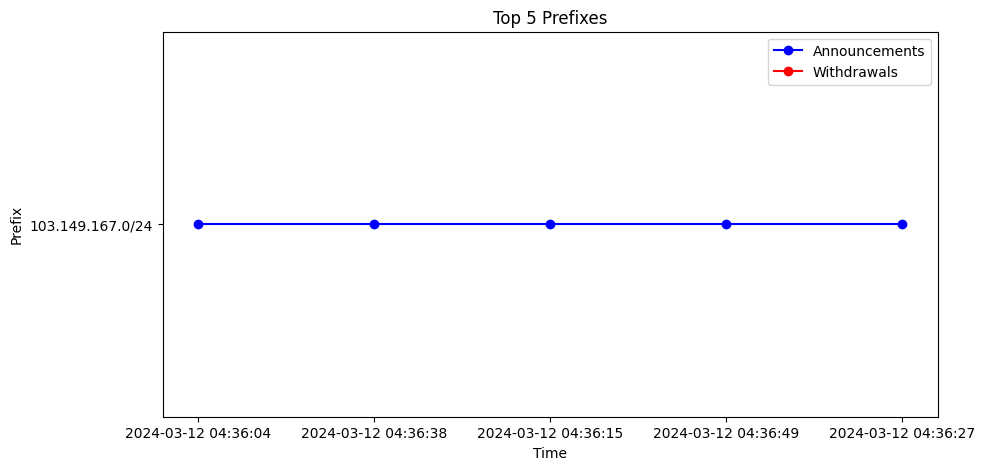

In [1]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

# Initialize BGPStream instance
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize DataFrames for announcements and withdrawals
announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])

def process_bgp_data(stop_time):
    global announcements, withdrawals
    end_time = time.time() + stop_time  # Calculate end time based on stop_time duration
    last_print_time = time.time()

    while time.time() < end_time:
        for rec in stream.records():
            for elem in rec:
                # Filter records with 7812 in the AS path
                as_path = elem.fields.get('as-path', '').split()
                if '24482' in as_path:
                    time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
                    prefix = elem.fields['prefix']
                    df = announcements if elem.type == 'A' else withdrawals
                    row_index = df[(df['Time'] == time_str) & (df['Prefix'] == prefix)].index
                    if row_index.empty:
                        df.loc[len(df)] = [time_str, prefix, 1]
                    else:
                        df.loc[row_index, 'Count'] += 1

            # Check if it's time to print and reset DataFrames (every 60 seconds)
            if time.time() - last_print_time >= 60:
                # Sort and get the top 5 prefixes by count for announcements
                top_announcements = announcements.sort_values(by='Count', ascending=False).head(5)
                # Sort and get the top 5 prefixes by count for withdrawals
                top_withdrawals = withdrawals.sort_values(by='Count', ascending=False).head(5)
                
                # Plot the top prefix announcements and withdrawals
                plt.figure(figsize=(10, 5))
                plt.plot(top_announcements['Time'], top_announcements['Prefix'], 'bo-', label='Announcements')
                plt.plot(top_withdrawals['Time'], top_withdrawals['Prefix'], 'ro-', label='Withdrawals')
                plt.xlabel('Time')
                plt.ylabel('Prefix')
                plt.title('Top 5 Prefixes')
                plt.legend()
                plt.show()
                
                announcements = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
                withdrawals = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
                last_print_time = time.time()  # Update last_print_time

    print("Data collection finished.")

# Define the total running time (180 seconds)
total_running_time = 180
process_bgp_data(total_running_time)

# Knowledge Test

In [6]:
import json
import re

input_file_path = "/home/hb/LLM-research/evaluation/BGP/bgp_test_multiple_choice_v2.json" 

with open(input_file_path, "r") as input_file:
    questions_data = json.load(input_file)

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=128)

generated_answers = []
ground_truth = [q_dict["answer"] for q_dict in questions_data]
n_question = 0

for q_dict in questions_data:
    question = q_dict["question"]
    options = q_dict["options"]
    
    # Construct prompt with question and options
    prompt = f"Choose the correct answer: {question}\n" + "\n".join(options)
    # print(prompt)
    
    # Generate answer using the language model
    generated_answer = pipe(prompt)[0]['generated_text']
    print(f"Generated Answer: {generated_answer}")
    
    # Parse the generated answer
    answer_lines = generated_answer.splitlines()
    parsed_answer = ""
    for line in answer_lines:
            if line.startswith("Answer: ") or line.startswith("Correct answer: "):
                parsed_answer = re.search(r'\b(\w)\)', line).group(1)
                print(f"Parsed_answer: {parsed_answer}")
                break
    generated_answers.append(parsed_answer)
    n_question += 1
    print(f"----------------{n_question}-----------------")
print(generated_answers)


total_questions = len(questions_data)
correct_answers = 0

for ground_answer, generated_answer in zip(ground_truth, generated_answers):
    if generated_answer.lower() == ground_answer.lower():
        print("Correct")
        correct_answers += 1
    else:
        print(f"GPT answer: {generated_answer}. Correct answer: {ground_answer}")
        print("Incorrect")

accuracy = (correct_answers / total_questions) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Correct answers: {correct_answers}")
print(f"Incorrect answers: {total_questions - correct_answers}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: When analyzing BGP route propagation, which attribute provides information about the path that the BGP update has traversed?
a) AS-Path
b) MED (Multi-Exit Discriminator)
c) Local Preference
d) Next Hop

Answer: a) AS-Path

Explanation: The AS-Path attribute is used to track the path that a BGP update has traversed. It is a list of Autonomous System (AS) numbers that the update has passed through. This attribute helps in identifying the path that the update has
Parsed_answer: a
----------------1-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: Which of the following is a primary purpose of BGP?
a) Establishing communication between devices within a LAN
b) Exchanging routing information between autonomous systems
c) Optimizing local network traffic
d) Assigning IP addresses to devices

Answer: b) Exchanging routing information between autonomous systems.

Explanation: BGP (Border Gateway Protocol) is a protocol used to exchange routing information between autonomous systems. It is used to establish communication between devices within a LAN, optimize local network traffic, and assign IP
Parsed_answer: b
----------------2-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the main function of the AS-Path attribute in BGP?
a) Identifying the IP address of the next hop
b) Preventing route hijacking
c) Specifying the exit point from an AS
d) Tracking the ASes a route has traversed

Answer: d) Tracking the ASes a route has traversed. The AS-Path attribute is used to track the ASes a route has traversed, allowing BGP routers to determine the best path to a destination. It is not used to identify the IP address of the next
Parsed_answer: d
----------------3-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: Which BGP attribute indicates the preferred exit point from an AS?
a) ORIGIN
b) LOCAL-PREF
c) NEXT-HOP
d) AS-PATH

Answer: c) NEXT-HOP

Explanation: The NEXT-HOP attribute indicates the IP address of the next-hop router for a particular route. This attribute is used to determine the preferred exit point from an Autonomous System (AS). The NEXT-HOP attribute is used by BGP routers to determine the best path to a
Parsed_answer: c
----------------4-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: Which BGP message is used to establish a BGP session?
a) KEEPALIVE
b) OPEN
c) UPDATE
d) NOTIFICATION

Answer: b) OPEN

Explanation: The OPEN message is used to establish a BGP session between two BGP peers. It is sent by the initiator of the session and contains information about the BGP version, the BGP identifier, and the BGP hold timer. The OPEN message is used to establish a BGP session and is the first message exchanged between two B
Parsed_answer: b
----------------5-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the primary purpose of the BGP NEXT-HOP attribute?
a) Specifies the IP address of the sender
b) Indicates the preferred exit point from an AS
c) Defines the next router in the path
d) Specifies the route's origin

Answer: c) Defines the next router in the path

Explanation: The BGP NEXT-HOP attribute is used to specify the next router in the path of a BGP route. It is used to indicate the IP address of the next router in the path,
Parsed_answer: c
----------------6-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: Which BGP message is used to advertise new or withdrawn routes?
a) KEEPALIVE
b) OPEN
c) UPDATE
d) NOTIFICATION

Answer: c) UPDATE

Explanation: The UPDATE message is used to advertise new or withdrawn routes. It is sent by a router to its peers to inform them of changes in the network. The KEEPALIVE message is used to maintain the connection between BGP peers, the OPEN message is used to establish a BGP session, and the NOTIF
Parsed_answer: c
----------------7-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the purpose of BGP route aggregation?
a) Breaking down large routes into smaller subnets
b) Combining multiple routes into a single summarized route
c) Assigning priority to specific routes
d) Applying policies to routes

Answer: b) Combining multiple routes into a single summarized route.

Explanation: BGP route aggregation is the process of combining multiple routes into a single summarized route. This helps reduce the size of the routing table and improve network performance. By combining multiple routes into a single summarized
Parsed_answer: b
----------------8-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the term for maliciously advertising IP prefixes an AS doesn't own?
a) BGP Route Hijacking
b) BGP Anomaly Detection
c) BGP Route Flap
d) BGP Route Aggregation

Answer: a) BGP Route Hijacking.

Explanation: BGP Route Hijacking is the term used to describe the malicious advertisement of IP prefixes an AS does not own. This can be done by an attacker to redirect traffic away from its intended destination, or
Parsed_answer: a
----------------9-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: BGP Prefix Origin Validation (ROV) is primarily aimed at preventing:
a) BGP route damping
b) BGP session establishment
c) BGP route leaks and hijacks
d) BGP route aggregation

Answer: c) BGP route leaks and hijacks.

Explanation: BGP Prefix Origin Validation (ROV) is a security feature that helps prevent route leaks and hijacks by verifying the origin of BGP routes. It ensures that routes are not propagated from an unexpected source
Parsed_answer: c
----------------10-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: Which BGP attribute is used to group routes into categories?
a) LOCAL-PREF
b) MED
c) AS-PATH
d) COMMUNITY

Answer: d) COMMUNITY

Explanation: The COMMUNITY attribute is used to group routes into categories. It is used to identify routes that are part of a specific community, such as a specific AS or a specific group of ASes. This attribute is used to influence route selection and to control the propagation of routes within a network.

Note: The other
Parsed_answer: d
----------------11-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: BGP confederations are used to:
a) Optimize local network traffic
b) Divide an AS into sub-ASes for scalability
c) Group routes into categories
d) Handle BGP session establishment

Answer: b) Divide an AS into sub-ASes for scalability. BGP confederations are used to divide an Autonomous System (AS) into sub-ASes, allowing for better scalability and improved performance. This is done by grouping multiple ASes into a single confederation, allowing them to share a single BGP
Parsed_answer: b
----------------12-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: Which BGP attribute is used to influence route selection by assigning a value to the route?
a) ORIGIN
b) MED
c) AS-PATH
d) LOCAL-PREF

Answer: d) LOCAL-PREF

Explanation: The LOCAL-PREF attribute is used to influence route selection by assigning a value to the route. This attribute is used to indicate the preference of a route within a single autonomous system. The higher the value, the more preferred the route is. This attribute is used to influence route selection
Parsed_answer: d
----------------13-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the purpose of the BGP NOTIFICATION message?
a) Establish a BGP session
b) Advertise new routes
c) Signal an error or event in the BGP session
d) Request a route refresh

Answer: c) Signal an error or event in the BGP session.

Explanation: The BGP NOTIFICATION message is used to signal an error or event in the BGP session. It is used to inform the other BGP peer of an error or event that has occurred in the session, such as a
Parsed_answer: c
----------------14-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the primary purpose of the BGP Community attribute?
a) Indicate the preferred exit point
b) Prevent route flapping
c) Define route policies based on grouping
d) Determine the AS-Path length

Answer: c) Define route policies based on grouping. The BGP Community attribute is used to group routes and define policies based on those groups. It allows for more granular control over route selection and can be used to influence the path taken by traffic. The other options are incorrect because the primary purpose of the BGP Community attribute is not to indicate the
Parsed_answer: c
----------------15-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: BGP Route Reflectors are used to address the scalability issues associated with:
a) Excessive route dampening
b) Route summarization
c) Full mesh BGP peering
d) BGP prefix hijacking

Answer: b) Route summarization. BGP Route Reflectors are used to address the scalability issues associated with route summarization. They reduce the number of BGP updates by summarizing routes and propagating them to other BGP peers. This helps to reduce the number of BGP updates and improve scalability.

Question
Parsed_answer: b
----------------16-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the primary purpose of the BGP Path Attribute?
a) Identify the exit point from an AS
b) Indicate the origin of a route
c) Determine the optimal route
d) Filter BGP routes

Answer: c) Determine the optimal route

Explanation: The primary purpose of the BGP Path Attribute is to determine the optimal route for a given destination. It contains information about the route, such as the origin AS, the AS path, the next hop, and the local preference. This information is used by BGP routers
Parsed_answer: c
----------------17-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: BGP Prefix Filtering is used to:
a) Prevent route hijacking
b) Optimize route propagation
c) Establish BGP sessions
d) Calculate BGP AS-Paths

Answer: a) Prevent route hijacking

Explanation: BGP Prefix Filtering is used to prevent route hijacking by allowing an administrator to filter out routes that are not desired. This is done by configuring a prefix list that specifies which routes should be accepted or rejected. By using prefix filtering, an administrator can prevent
Parsed_answer: a
----------------18-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: In BGP, what is the primary purpose of the ORIGIN attribute?
a) Identify the exit point from an AS
b) Determine the preferred route within an AS
c) Indicate the origin of a route
d) Assign values for path selection

Answer: c) Indicate the origin of a route. The ORIGIN attribute is used to indicate the origin of a route, such as an IGP or an EGP. It is used to identify the source of a route and to determine the preferred route within an AS. It is not used to
Parsed_answer: c
----------------19-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What does the BGP Maximum Prefix Limit control?
a) The number of BGP routes that can be aggregated
b) The maximum length of the AS-Path attribute
c) The number of prefixes a BGP router will accept
d) The BGP route redistribution process

Answer: c) The number of prefixes a BGP router will accept. The BGP Maximum Prefix Limit controls the number of prefixes a BGP router will accept from its peers. This limit is used to prevent the router from accepting too many prefixes
Parsed_answer: c
----------------20-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the purpose of the BGP Large Communities attribute?
a) Determine the optimal route path
b) Prevent BGP session timeouts
c) Provide more efficient route summarization
d) Group routes into categories based on policies

Answer: c) Provide more efficient route summarization. The BGP Large Communities attribute is used to group routes into categories based on policies, allowing for more efficient route summarization. It is not used to determine the optimal route path, prevent BGP session timeouts, or group routes into categories based on policies.
Parsed_answer: c
----------------21-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: In BGP, what is the significance of the BGP Weight attribute?
a) It determines the exit point from an AS
b) It influences the route selection within an AS
c) It specifies the BGP session timeout value
d) It defines the route origin

Answer: b) It influences the route selection within an AS

Explanation: The BGP Weight attribute is used to influence the route selection within an Autonomous System (AS). It is used to prioritize routes within an AS, allowing the network administrator to control the
Parsed_answer: b
----------------22-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: How does the BGP AS Confederation help address the full mesh peering challenge?
a) It reduces the number of AS-Path segments
b) It introduces hierarchical routing within a single AS
c) It increases the number of BGP sessions between routers
d) It optimizes the BGP Weight attribute

Answer: b) It introduces hierarchical routing within a single AS.

Explanation: BGP AS Confederation is a technique used to address the full mesh peering challenge by introducing hierarchical routing within a single AS.
Parsed_answer: b
----------------23-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is BGPsec and how does it enhance BGP security?
a) BGPsec is a protocol for secure BGP session establishment
b) BGPsec is an extension to BGP that adds cryptographic verification to BGP route announcements
c) BGPsec is a mechanism for prefix aggregation in BGP
d) BGPsec is used to prevent BGP route leaks

Answer: b) BGPsec is an extension to BGP that adds cryptographic verification to BGP route announcements. BGPsec is a protocol that
Parsed_answer: b
----------------24-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: When is the BGP Extended Community attribute used, and what information does it convey?
a) It is used for route summarization within a single AS
b) It conveys policy information and inter-domain actions associated with a route
c) It determines the local preference of a BGP route
d) It specifies the AS-Path segment of a route

Answer: b) It conveys policy information and inter-domain actions associated with a route.

Explanation: The BGP Extended Community attribute is used to convey policy information and inter-
Parsed_answer: b
----------------25-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Input length of input_ids is 141, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


Generated Answer: Choose the correct answer: What is the concept of BGP Flowspec, and how does it enhance BGP routing control?
a) BGP Flowspec is a mechanism to advertise real-time network traffic statistics
b) BGP Flowspec is used for route aggregation in large networks
c) BGP Flowspec allows the dissemination of traffic filtering rules using BGP updates
d) BGP Flowspec determines the AS-Path of a route

Answer: c) BGP Flowspec allows the dissemination of traffic filtering rules using BGP updates. BGP Flowspec is a
Parsed_answer: c
----------------26-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: Explain the difference between BGP Route Reflection and BGP Confederations.
a) BGP Route Reflection optimizes BGP sessions within an AS, while BGP Confederations divide an AS into smaller sub-ASes for scalability
b) BGP Route Reflection is used to group BGP routes, while BGP Confederations enhance BGP security
c) BGP Route Reflection is a method to prevent BGP route hijacking, while BGP Confederations manage BGP community attributes
d) BGP Route Reflection establishes BGP sessions between ASes, while BGP Confederations control the BGP Weight attribute

----------------27-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is BGP Route Damping, and how does it impact BGP routing stability?
a) BGP Route Damping is a mechanism to prevent BGP prefix aggregation, ensuring route granularity
b) BGP Route Damping is a technique to mitigate the impact of BGP prefix hijacking
c) BGP Route Damping is used to reduce the rate of BGP route updates in response to route flapping
d) BGP Route Damping is a security feature that encrypts BGP updates to prevent eavesdropping

----------------28-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Input length of input_ids is 133, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


Generated Answer: Choose the correct answer: How does BGP Prefix Hijacking occur, and what are the potential consequences?
a) BGP Prefix Hijacking occurs when BGP sessions are established without proper authentication, leading to data leaks
b) BGP Prefix Hijacking involves advertising IP prefixes an AS doesn't own, potentially redirecting traffic to unauthorized paths
c) BGP Prefix Hijacking is a result of BGP session timeouts causing route instability
d) BGP Prefix Hijacking is a technique to achieve BGP route summarization


----------------29-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the purpose of the BGP RPKI (Resource Public Key Infrastructure) framework, and how does it enhance BGP security?
a) BGP RPKI is used for route reflection in BGP Confederations, enhancing scalability
b) BGP RPKI provides cryptographic verification of BGP route announcements, preventing prefix hijacking
c) BGP RPKI optimizes the BGP Local Preference attribute for route selection
d) BGP RPKI is a mechanism for BGP prefix aggregation, reducing the number of routes exchanged

----------------30-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Input length of input_ids is 140, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


Generated Answer: Choose the correct answer: Describe the purpose of the BGP FlowSpec Redirect action and how it affects network traffic.
a) BGP FlowSpec Redirect is used to filter incoming BGP routes based on their AS-Path
b) BGP FlowSpec Redirect redirects incoming network traffic matching specified criteria to a designated next-hop
c) BGP FlowSpec Redirect increases the BGP session timeout value, reducing BGP convergence time
d) BGP FlowSpec Redirect optimizes the BGP Weight attribute for route selection

Answer: b) BGP FlowSpec Redirect redirects
Parsed_answer: b
----------------31-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What is the difference between BGP Route Refresh and BGP Full Withdraw?
a) BGP Route Refresh is used to advertise new routes, while BGP Full Withdraw indicates route errors
b) BGP Route Refresh is a mechanism for re-advertising BGP routes, while BGP Full Withdraw removes all prefixes associated with a peer
c) BGP Route Refresh is used for BGP prefix aggregation, while BGP Full Withdraw triggers route convergence
d) BGP Route Refresh optimizes the BGP LOCAL-PREF attribute, while BGP Full Withdraw prevents route flapping

----------------32-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Input length of input_ids is 128, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


Generated Answer: Choose the correct answer: How does the BGP Add-Path feature enhance BGP route selection and convergence?
a) BGP Add-Path enables BGP routers to advertise multiple alternate paths for a given prefix
b) BGP Add-Path decreases the BGP session establishment time, enhancing route convergence
c) BGP Add-Path optimizes the BGP Weight attribute for route selection
d) BGP Add-Path prevents BGP prefix hijacking by adding cryptographic signatures to BGP updates

Answer: a) BGP Add-Path enables BGP rou
Parsed_answer: a
----------------33-----------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated Answer: Choose the correct answer: What are BGP Route Reflection Clusters, and how do they contribute to BGP scalability?
a) BGP Route Reflection Clusters are used to enhance BGP security by encrypting BGP updates
b) BGP Route Reflection Clusters group routers within an AS, reducing the number of BGP sessions needed for route reflection
c) BGP Route Reflection Clusters prevent BGP prefix hijacking by using cryptographic verification
d) BGP Route Reflection Clusters optimize the BGP MED attribute for efficient route selection

----------------34-----------------
Generated Answer: Choose the correct answer: Explain the concept of BGP PIC (Prefix Independent Convergence) and its significance in enhancing network reliability.
a) BGP PIC ensures that BGP routers converge to the same routing table in the event of network failures
b) BGP PIC introduces route summarization to improve BGP scalability
c) BGP PIC reduces the BGP session establishment time, enhancing route convergence
d)

In [ ]:
import json
import re

input_file_path = "/home/hb/LLM-research/evaluation/bgp_test_fill_the_blank.json" 

with open(input_file_path, "r") as input_file:
    questions_data = json.load(input_file)

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=128)

generated_answers_fb = []
filled_answers = []

n_question = 0
for q_dict in questions_data:
    question = q_dict["question"]
    answer = q_dict["answer"]

    # Generate answer using the language model
    prompt = f"[INST]{question} \n Fill the blank: \n [/INST]"
    generated_answer = pipe(prompt)[0]['generated_text']
    print(f"Output: {generated_answer}")
    generated_answers_fb.append(generated_answer)
    
    generated_answer = re.search(r'\[/INST\]\s+(.*)', generated_answer).group(1).strip()
    if "Sure" in generated_answer:
        generated_lines = generated_answer.split('\n')
        if len(generated_lines) > 1:
            generated_answer = '\n'.join(generated_lines[1:])  # Skip the first line
    # generated_answers_fb.append(generated_answer)
    # print(f"Generated answer: {generated_answer}")
    # Find the position of the placeholder in the first string
    placeholder_position = question.find("________")

    # Extract the content filled in the placeholder
    filled_content = generated_answer[placeholder_position:placeholder_position + len("autonomous systems (ASes)")]
    filled_answers.append(filled_content)
    n_question += 1
    print(f"Filled content: {filled_content}")
    print(f"---------------------{n_question}-----------------------------")

In [ ]:
input_file_path = "/home/hb/LLM-research/evaluation/bgp_test_QA_val.json" 

with open(input_file_path, "r") as input_file:
    questions_data = json.load(input_file)

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)

generated_answers_qa = []

n_question = 0
for q_dict in questions_data:
    n_question += 1
    question = q_dict["question"]
    # Generate answer using the language model
    prompt = f"[INST]{question}[/INST]"
    generated_answer = pipe(prompt)[0]['generated_text']
    print(f"Output: {generated_answer}")
    generated_answers_qa.append(generated_answer)
    print(f"---------------------{n_question}-----------------------------")

### LLaMA2-7B:
`Multiple Choice v2`:
    Accuracy: 48.57%
    Correct answers: 17
    Incorrect answers: 18

`Multiple Choice v1`:
    Accuracy: 51.43%
    Correct answers: 18
    Incorrect answers: 17

### LLaMA2-13B:
`Multiple Choice v2`:
    Accuracy: 60.00%
    Correct answers: 21
    Incorrect answers: 14

`Multiple Choice v1`:
    Accuracy: 71.43%
    Correct answers: 25
    Incorrect answers: 10

### BGPtest9- cosine - `Best`:
`Multiple Choice v2`:
    Accuracy: 68.57%
    Correct answers: 24
    Incorrect answers: 11

`Multiple Choice v1`:
    - Accuracy: 82.86%
    - Correct answers: 29
    - Incorrect answers: 6

### BGPtest10- constant:
`Multiple Choice v2`:
    Accuracy: 62.86%
    Correct answers: 22
    Incorrect answers: 13

`Multiple Choice v1`:
    - Accuracy: 71.43%
    - Correct answers: 25
    - Incorrect answers: 10

`Fill the blank v1`:
    - Accuracy: 88.57%
    - Correct answers: 31
    - Incorrect answers: 4

`Fill the blank v2`:
    - Accuracy: 91.42%
    - Correct answers: 33
    - Incorrect answers: 2


### BGP-LLaMA-1-cosine-2k-alpha64:
`Multiple Choice v2`:
    Accuracy: 51.43%
    Correct answers: 18
    Incorrect answers: 17

`Multiple Choice v1`:
    Accuracy: 68.57%
    Correct answers: 24
    Incorrect answers: 11

### BGP-LLaMA-2-cosine-20k-alpha16:
`Multiple Choice v1`:
    Accuracy: 68.57%
    Correct answers: 24
    Incorrect answers: 11

`Multiple Choice v2`:
    Accuracy: 54.29%
    Correct answers: 19
    Incorrect answers: 16


### BGP-LLaMA-2(combined)-cosine-20k-alpha16:
`Multiple Choice v1`:
    Accuracy: 80.00%
    Correct answers: 28
    Incorrect answers: 7

`Multiple Choice v2`:

    Accuracy: 65.71%
    Correct answers: 23
    Incorrect answers: 12

### BGP-LLaMA-13b-2iter-40k-cutoff-max-2048: ??
`Multiple Choice v1`:
    Accuracy: 77.14%
    Correct answers: 27
    Incorrect answers: 8

    
`Multiple Choice v2`:
    Accuracy: 62.86%
    Correct answers: 22
    Incorrect answers: 13

`PyBGPStream`: not pass

### BGP-LLaMA-13b-3-30k-cutoff-max-2048:
`Multiple Choice v1`:
    Accuracy: 57.14%
    Correct answers: 20
    Incorrect answers: 15

`Multiple Choice v2`:
    Accuracy: 54%

`PyBGPStream`: pass

### BGP-LLaMA-13b-50k-cutoff-max-2048: 
`Multiple Choice v1`:
    Accuracy: 60.00%
    Correct answers: 21
    Incorrect answers: 14
`PyBGPStream`: pass

### BGP-LLaMA-13b-20k-cutoff-max-2048: 
`Multiple Choice v1`
    Accuracy: 48.57%
    Correct answers: 17
    Incorrect answers: 18
`PyBGPStream`: pass


### BGP-LLaMA-13b-20k-cutoff-1024-max-none:
`Multiple Choice v1`
    Accuracy: 45.71%
    Correct answers: 16
    Incorrect answers: 19
`PyBGPStream`: pass


### BGP-LLaMA-13b-30k-cutoff-1024-max-none:
`Multiple Choice v1`
Accuracy: 62.86%
Correct answers: 22
Incorrect answers: 13

`PyBGPStream`: pass


### BGP-LLaMA-13b-40k-cutoff-1024-max-none:
`Multiple Choice v1`
    Accuracy: 48.57%
    Correct answers: 17
    Incorrect answers: 18
`PyBGPStream`: not pass

### BGP-LLaMA-13b-50k-cutoff-1024-max-none:
`Multiple Choice v1`
    Accuracy: 40.00%
    Correct answers: 14
    Incorrect answers: 21
`PyBGPStream`: not pass


### BGP-LLaMA26k-13b-30k-cutoff-1024-max-None:
`Multiple Choice v1`: not pass

`PyBGPStream`: pass

### BGP-LLaMA26k-13b-20k-cutoff-1024-max-None:
`Multiple Choice v1`:
Incorrect
Accuracy: 37.14%
Correct answers: 13
Incorrect answers: 22
`PyBGPStream`: pass

### BGP-LLaMA26k-13b-10k-cutoff-1024-max-2048
`Multiple Choice v1`:
Accuracy: 62.86%
Correct answers: 22
Incorrect answers: 13
`PyBGPStream`: pass (better than previous)


### BGP-LLaMA26k-13b-5k-cutoff-1024-max-2048 - `Best Combined`
`Multiple Choice v1`:
Accuracy: 82.86%
Correct answers: 29
Incorrect answers: 6

`Multiple Choice v2`:
Accuracy: 71.43%
Correct answers: 25
Incorrect answers: 10

### BGP-LLaMA-knowledge-20k-cutoff-1024-max-2048
`Multiple Choice v1`:
Accuracy: 62.86%
Correct answers: 22
Incorrect answers: 13

`Multiple Choice v2`:
Accuracy: 48.57%
Correct answers: 17
Incorrect answers: 18

### BGP-LLaMA-knowledge-5k-cutoff-1024-max-2048 `best knowledge`
`Multiple Choice v1`:
Accuracy: 85.71%
Correct answers: 30
Incorrect answers: 5

`Multiple Choice v2`:
Accuracy: 71.43%
Correct answers: 25
Incorrect answers: 10

### BGP-LLaMA-knowledge-3k-cutoff-1024-max-2048
`Multiple Choice v1`:
Accuracy: 82.86%
Correct answers: 29
Incorrect answers: 6

`Multiple Choice v2`:
Accuracy: 74.29%
Correct answers: 26
Incorrect answers: 9

### BGP-LLaMA-knowledge-2k-cutoff-1024-max-2048
`Multiple Choice v1`:
Accuracy: 82.86%
Correct answers: 29
Incorrect answers: 6

`Multiple Choice v2`:
Accuracy: 71.43%
Correct answers: 25
Incorrect answers: 10